In [1]:
from glob import glob
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Ensure the path is correct and matches your file system structure
path_to_files = "C:/Users/vishw/Downloads/eeg-during-mental-arithmetic-tasks-1.0.0/eeg-during-mental-arithmetic-tasks-1.0.0/*.edf"
all_edf_files = glob(path_to_files)

In [3]:
# Separate rest and task data based on file names
rest_data = [i for i in all_edf_files if i.endswith('_1.edf')]
rawtask_data = [i for i in all_edf_files if i.endswith('_2.edf')]

# Print the lists to verify
print("\nRest Data:")
print(rest_data)
print("\nRaw Task Data:")
print(rawtask_data)


Rest Data:
['C:/Users/vishw/Downloads/eeg-during-mental-arithmetic-tasks-1.0.0/eeg-during-mental-arithmetic-tasks-1.0.0\\Subject00_1.edf', 'C:/Users/vishw/Downloads/eeg-during-mental-arithmetic-tasks-1.0.0/eeg-during-mental-arithmetic-tasks-1.0.0\\Subject01_1.edf', 'C:/Users/vishw/Downloads/eeg-during-mental-arithmetic-tasks-1.0.0/eeg-during-mental-arithmetic-tasks-1.0.0\\Subject02_1.edf', 'C:/Users/vishw/Downloads/eeg-during-mental-arithmetic-tasks-1.0.0/eeg-during-mental-arithmetic-tasks-1.0.0\\Subject03_1.edf', 'C:/Users/vishw/Downloads/eeg-during-mental-arithmetic-tasks-1.0.0/eeg-during-mental-arithmetic-tasks-1.0.0\\Subject04_1.edf', 'C:/Users/vishw/Downloads/eeg-during-mental-arithmetic-tasks-1.0.0/eeg-during-mental-arithmetic-tasks-1.0.0\\Subject05_1.edf', 'C:/Users/vishw/Downloads/eeg-during-mental-arithmetic-tasks-1.0.0/eeg-during-mental-arithmetic-tasks-1.0.0\\Subject06_1.edf', 'C:/Users/vishw/Downloads/eeg-during-mental-arithmetic-tasks-1.0.0/eeg-during-mental-arithmetic-ta

In [4]:
%%capture
new_rest_data = mne.io.read_raw_edf(rest_data[0], preload=True)
new_rest_data.set_eeg_reference()
new_rest_data.filter(l_freq=0.5, h_freq=45)

Extracting EDF parameters from C:\Users\vishw\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Extracting EDF parameters from C:\Users\vishw\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0\Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel 

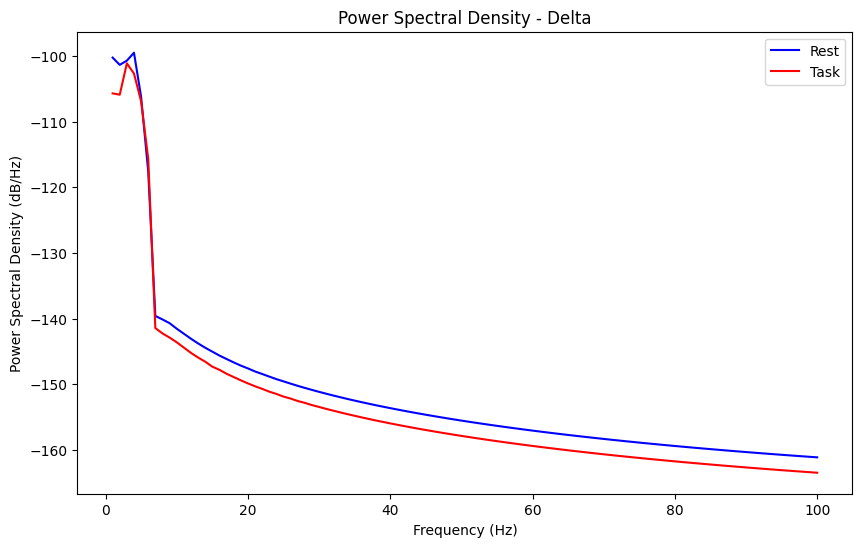

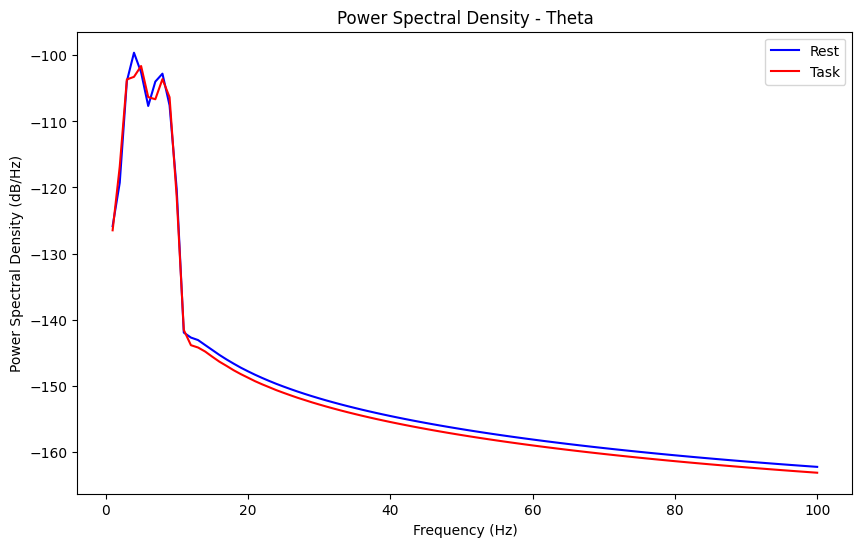

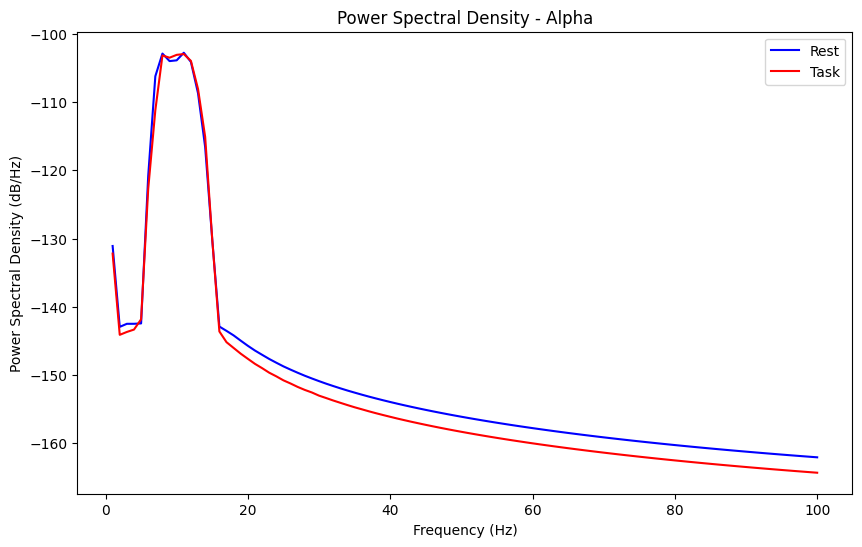

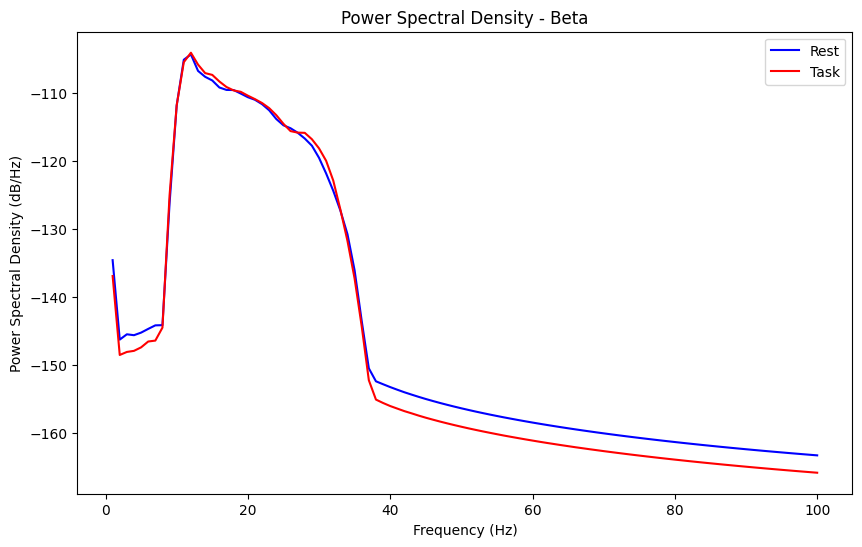

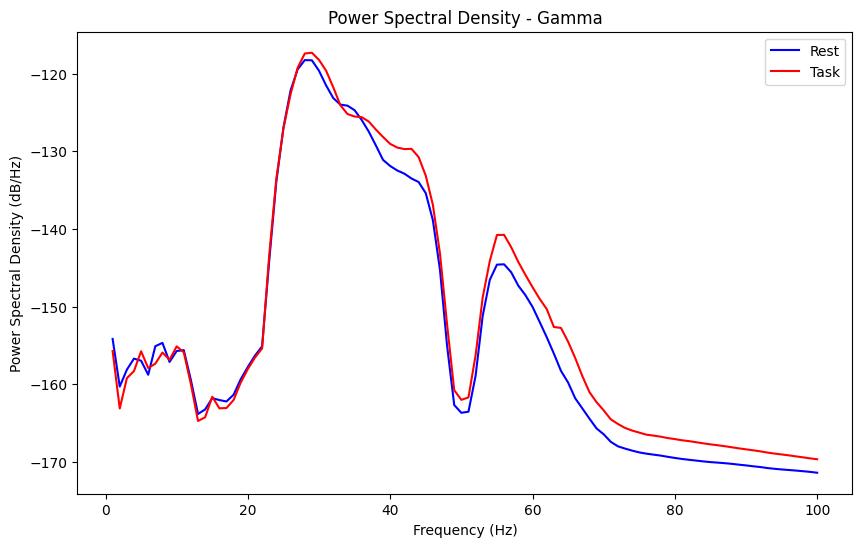

In [5]:
import mne
import numpy as np
import matplotlib.pyplot as plt

freq_bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 100)
}

# Function to calculate PSD for a given dataset
def calculate_psd(data):
    psds, freqs = mne.time_frequency.psd_array_welch(data.get_data(), sfreq=data.info['sfreq'], fmin=0.5, fmax=100, n_fft=500)
    return psds, freqs

# Function to process each dataset and calculate PSD for each frequency band
def process_data(data_paths):
    psds_all = []
    for data_path in data_paths:
        raw_data = mne.io.read_raw_edf(data_path, preload=True)
        raw_data.set_eeg_reference('average', projection=True)  # Setting average reference with projection
        raw_data.filter(l_freq=0.5, h_freq=100, verbose=False)
        
        psds_band = {}
        for band, (low, high) in freq_bands.items():
            raw_data_band = raw_data.copy().filter(l_freq=low, h_freq=high, verbose=False)
            psds, freqs = calculate_psd(raw_data_band)
            psds_band[band] = psds.mean(axis=0)  # Average across channels

        psds_all.append(psds_band)
    
    return psds_all, freqs

psds_rest, freqs = process_data(rest_data)
psds_task, freqs = process_data(rawtask_data)

# Plotting PSDs for comparison in separate figures
for band in freq_bands.keys():
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, 10 * np.log10(psds_rest[0][band]), label='Rest', color='blue')
    plt.plot(freqs, 10 * np.log10(psds_task[0][band]), label='Task', color='red')
    plt.title(f'Power Spectral Density - {band}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.legend()
    plt.show()

# EEGNet model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Load and preprocess EEG data
def preprocess_data(data_paths, labels, freq_bands):
    features = []
    target = []

    for i, data_path in enumerate(data_paths):
        raw_data = mne.io.read_raw_edf(data_path, preload=True)
        raw_data.set_eeg_reference('average', projection=True)
        raw_data.filter(l_freq=0.5, h_freq=100, verbose=False)

        for band, (low, high) in freq_bands.items():
            raw_data_band = raw_data.copy().filter(l_freq=low, h_freq=high, verbose=False)
            psds, freqs = calculate_psd(raw_data_band)
            features.append(psds.mean(axis=0))
            target.append(labels[i])
    
    features = np.array(features)
    target = np.array(target)

    return features, target

In [7]:
labels = [0] * len(rest_data) + [1] * len(rawtask_data)  # 0 for rest, 1 for task

all_data = rest_data + rawtask_data
features, target = preprocess_data(all_data, labels, freq_bands)

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# One-hot encoding of labels for Keras
target = to_categorical(target)

Extracting EDF parameters from C:\Users\vishw\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Extracting EDF parameters from C:\Users\vishw\Downloads\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0\Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel 

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization, Activation, AveragePooling1D, Dropout, Flatten

def build_eegnet_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # First convolutional block
    x = Conv1D(16, 10, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling1D(2)(x)
    x = Dropout(0.5)(x)

    # Second convolutional block
    x = Conv1D(32, 10, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling1D(2)(x)
    x = Dropout(0.5)(x)

    # Third convolutional block
    x = Conv1D(64, 10, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling1D(2)(x)
    x = Dropout(0.5)(x)

    # Flatten and output layer
    x = Flatten()(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Assuming features are already preprocessed and reshaped
input_shape = (features.shape[1], 1)  # Adjust based on your actual data dimensions
eegnet_model = build_eegnet_model(input_shape)
eegnet_model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 16)           176       
                                                                 
 batch_normalization (Batch  (None, 100, 16)           64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 100, 16)           0         
                                                                 
 average_pooling1d (Average  (None, 50, 16)            0         
 Pooling1D)                                                      
                                                                 
 dropout (Dropout)           (None, 50, 16)            0  

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (features.shape[1], 1)
eegnet_model = build_eegnet_model(input_shape)

# Preprocess data
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Reshape data for EEGNet (for Conv1D the shape should be (samples, timesteps, features))
X_train_eegnet = X_train.reshape(-1, features.shape[1], 1)
X_val_eegnet = X_val.reshape(-1, features.shape[1], 1)

# Fit the model
history = eegnet_model.fit(
    X_train_eegnet, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_eegnet, y_val),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = eegnet_model.evaluate(X_val_eegnet, y_val)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

Epoch 1/100


9/9 [==============================] - 4s 74ms/step - loss: 0.9134 - accuracy: 0.5312 - val_loss: 0.7344 - val_accuracy: 0.4444
Epoch 2/100
9/9 [==============================] - 0s 14ms/step - loss: 0.9074 - accuracy: 0.5000 - val_loss: 0.7085 - val_accuracy: 0.5139
Epoch 3/100
9/9 [==============================] - 0s 17ms/step - loss: 0.9118 - accuracy: 0.5139 - val_loss: 0.7039 - val_accuracy: 0.5000
Epoch 4/100
9/9 [==============================] - 0s 15ms/step - loss: 0.8422 - accuracy: 0.5382 - val_loss: 0.7194 - val_accuracy: 0.4583
Epoch 5/100
9/9 [==============================] - 0s 15ms/step - loss: 0.8894 - accuracy: 0.5208 - val_loss: 0.7355 - val_accuracy: 0.4167
Epoch 6/100
9/9 [==============================] - 0s 15ms/step - loss: 0.8250 - accuracy: 0.5243 - val_loss: 0.7194 - val_accuracy: 0.5000
Epoch 7/100
9/9 [==============================] - 0s 15ms/step - loss: 0.8537 - accuracy: 0.5035 - val_loss: 0.7138 - val_accuracy: 0.4306
Epoch 8/100
9/9 [=

In [12]:
from sklearn.metrics import classification_report

# Predict on validation data
y_pred = eegnet_model.predict(X_val_eegnet)

# Convert predictions to classes
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Generate classification report
report = classification_report(y_val_classes, y_pred_classes)
print(report)

3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.54      0.19      0.28        37
           1       0.49      0.83      0.62        35

    accuracy                           0.50        72
   macro avg       0.51      0.51      0.45        72
weighted avg       0.52      0.50      0.44        72

